In [2]:
import pandas as pd
from binance.client import Client
import ta.trend
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting import set_bokeh_output
set_bokeh_output(notebook=True)

d:\miniconda3\Lib\site-packages\backtesting\_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

d:\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1. Get some data

In [3]:
def transform_df(df):

    df = df.iloc[:,:6]
    df.columns = ['Date','Open','High','Low','Close','Volume']
    df['Date'] = pd.to_datetime(df['Date'], unit='ms', utc=True)
    df.set_index('Date', inplace=True)
    df.index = df.index.tz_convert('America/New_York')

    for c in df.columns:
        df[c] = df[c].astype('float')

    return df

In [8]:
client = Client()
df = pd.DataFrame(client.get_historical_klines(symbol='ETHUSDT',
                                          interval=Client.KLINE_INTERVAL_1MINUTE,
                                          start_str='6 hour ago'))

df = transform_df(df)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2025-02-27 06:59:00-05:00 to 2025-02-27 12:58:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    360 non-null    float64
 1   High    360 non-null    float64
 2   Low     360 non-null    float64
 3   Close   360 non-null    float64
 4   Volume  360 non-null    float64
dtypes: float64(5)
memory usage: 16.9 KB
None
                              Open     High      Low    Close     Volume
Date                                                                    
2025-02-27 06:59:00-05:00  2351.48  2354.19  2351.47  2353.82   146.4472
2025-02-27 07:00:00-05:00  2353.83  2354.76  2351.36  2351.79   287.1631
2025-02-27 07:01:00-05:00  2351.80  2355.20  2351.10  2355.08   353.9423
2025-02-27 07:02:00-05:00  2355.08  2356.81  2353.72  2356.31  1155.2680
2025-02-27 07:03:00-05:00  2356.32  2356.89  2351.71  2352.54   226.7941


In [5]:
df['macd'] = ta.trend.macd(df['Close'], 26, 12)
df['macd_signal'] = ta.trend.macd_signal(df['Close'], 26, 12, 9)

df = df.dropna()

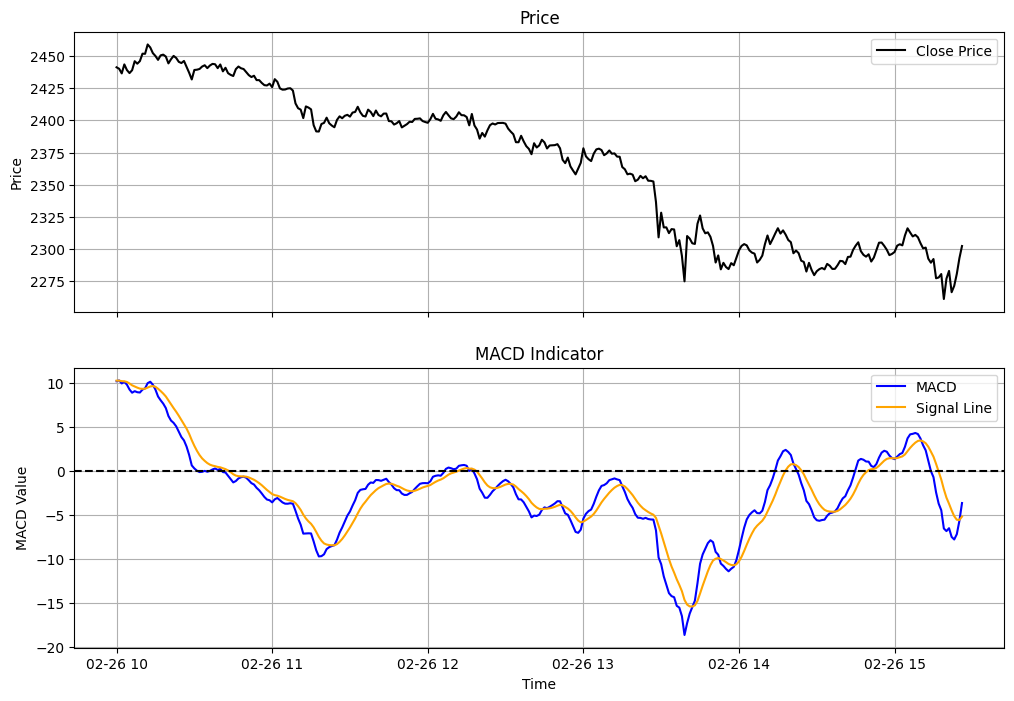

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot price
axes[0].plot(df.index, df['Close'], label='Close Price', color='black')
axes[0].set_title('Price')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot MACD and Signal Line
axes[1].plot(df.index, df['macd'], label='MACD', color='blue')
axes[1].plot(df.index, df['macd_signal'], label='Signal Line', color='orange')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('MACD Indicator')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('MACD Value')
axes[1].legend()
axes[1].grid(True)

plt.show()

#### 2. Define Strategy

In [4]:
class MACD_RSI(Strategy):

    # MACD parameters
    n_slow = 26
    n_fast = 12
    n_sig = 9

    # RSI parameters
    rsi_period = 14
    rsi_buy_threshold = 35
    rsi_sell_threshold = 65

    # Stop Loss & Take Profit (percentage)
    stop_loss_pct = 0.02  # 2% Stop Loss
    take_profit_pct = 0.04  # 4% Take Profit

    def init(self):
        close = self.data.Close

        self.macd = self.I(ta.trend.macd, pd.Series(close), self.n_slow, self.n_fast)
        self.macd_signal = self.I(ta.trend.macd_signal, pd.Series(close), self.n_slow, self.n_fast,self.n_sig)

        self.rsi = self.I(ta.momentum.rsi, pd.Series(close), self.rsi_period)

    def next(self):
        price = self.data.Close[-1]  # Get the current close price

        if crossover(self.macd, self.macd_signal) and self.rsi[-1] < self.rsi_buy_threshold:  # Buy signal
            self.position.close()  
            self.buy(
                sl=price * (1 - self.stop_loss_pct),  
                tp=price * (1 + self.take_profit_pct)  
            )

        elif crossover(self.macd_signal, self.macd) and self.rsi[-1] > self.rsi_sell_threshold:  # Sell signal
            self.position.close()  
            self.sell(
                sl=price * (1 + self.stop_loss_pct),  
                tp=price * (1 - self.take_profit_pct)  
            )

In [5]:
class MACDcross(Strategy):
    n_slow = 26
    n_fast = 12
    n_sig = 9

    stop_loss_pct = 0.003  
    take_profit_pct = 0.04  

    def init(self):
        close = self.data.Close
        self.macd = self.I(ta.trend.macd, pd.Series(close), self.n_slow, self.n_fast)
        self.macd_signal = self.I(ta.trend.macd_signal, pd.Series(close), self.n_slow, self.n_fast, self.n_sig)

    def next(self):
        price = self.data.Close[-1]  # Get the current close price

        if crossover(self.macd, self.macd_signal):  # Buy signal
            self.position.close()  
            self.buy(
                sl=price * (1 - self.stop_loss_pct),  
                tp=price * (1 + self.take_profit_pct) 
            )

        elif crossover(self.macd_signal, self.macd):  # Sell signal
            self.position.close()  
            self.sell(
                sl=price * (1 + self.stop_loss_pct),  
                tp=price * (1 - self.take_profit_pct)  
            )


In [6]:
class MACD_TSL(Strategy):
    # MACD parameters
    n_slow = 26
    n_fast = 12
    n_sig = 9

    stop_loss_pct = 0.003  # 0.3% Stop Loss
    trailing_stop_pct = 0.01  # 1% Trailing Stop Loss

    def init(self):
        close = self.data.Close

        # Compute MACD and Signal Line
        self.macd = self.I(ta.trend.macd, pd.Series(close), self.n_slow, self.n_fast)
        self.macd_signal = self.I(ta.trend.macd_signal, pd.Series(close), self.n_slow, self.n_fast, self.n_sig)

        # Rolling highest and lowest prices for trailing stop
        self.rolling_high = self.I(lambda x: pd.Series(x).rolling(5).max(), close)
        self.rolling_low = self.I(lambda x: pd.Series(x).rolling(5).min(), close)

    def next(self):
        price = self.data.Close[-1]  # Current closing price
        rolling_high = self.rolling_high[-1]  # Rolling highest price over 10 bars
        rolling_low = self.rolling_low[-1]  # Rolling lowest price over 10 bars

        # Buy Condition: MACD crosses above Signal
        if crossover(self.macd, self.macd_signal):
            self.position.close()  # Close any existing position
            self.buy(
                sl=price * (1 - self.stop_loss_pct)  # Stop Loss at 0.3% below entry
            )

        # Sell Condition: MACD crosses below Signal
        elif crossover(self.macd_signal, self.macd):
            self.position.close()  # Close any existing position
            self.sell(
                sl=price * (1 + self.stop_loss_pct)  # Stop Loss at 0.3% above entry
            )

        # Trailing Stop Loss Logic
        if self.position.is_long:  # If in a long (buy) position
            if price < rolling_high * (1 - self.trailing_stop_pct):  # Price drops 1% from highest
                self.position.close()  # Take profit (trailing stop triggered)

        elif self.position.is_short:  # If in a short (sell) position
            if price > rolling_low * (1 + self.trailing_stop_pct):  # Price rises 1% from lowest
                self.position.close()  # Take profit (trailing stop triggered)


#### 3. Run Backtest

In [80]:
bt = Backtest(df, MACD_TSL, cash=100000, commission=0.0005)
output = bt.run()

In [81]:
output

Start                     2025-02-26 10:00...
End                       2025-02-26 15:26...
Duration                      0 days 05:26:00
Exposure Time [%]                     73.3945
Equity Final [$]                 100437.76846
Equity Peak [$]                  102205.49846
Commissions [$]                    2059.90654
Return [%]                            0.43777
Buy & Hold Return [%]                -5.70618
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
CAGR [%]                          12832.02564
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                     -2.6694
Avg. Drawdown [%]                    -1.07311
Max. Drawdown Duration        0 days 02:05:00
Avg. Drawdown Duration        0 days 00:36:00
# Trades                                   21
Win Rate [%]                         33.33333
Best Trade [%]                    

In [48]:
output._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,ReturnPct,EntryTime,ExitTime,Duration,Tag,"Entry_macd(26,12)","Exit_macd(26,12)","Entry_macd_sign…(26,12,9)","Exit_macd_sign…(26,12,9)"
0,40,38,43,2443.79,2436.46860,NaN,2541.5520,-292.85600,-0.002996,2025-02-26 10:38:00-05:00,2025-02-26 10:43:00-05:00,0 days 00:05:00,None,-0.894810,-1.357616,-1.179979,-1.122954
1,-40,44,48,2436.60,2441.75000,2443.90980,2339.1360,-206.00000,-0.002114,2025-02-26 10:44:00-05:00,2025-02-26 10:48:00-05:00,0 days 00:04:00,None,-1.689706,-1.276226,-1.236304,-1.428722
2,40,48,52,2441.75,2435.04000,2434.42475,2539.4200,-268.40000,-0.002748,2025-02-26 10:48:00-05:00,2025-02-26 10:52:00-05:00,0 days 00:04:00,None,-1.276226,-1.805263,-1.428722,-1.469375
3,-40,52,85,2435.04,2394.61000,2442.34512,2337.6384,1617.20000,0.016603,2025-02-26 10:52:00-05:00,2025-02-26 11:25:00-05:00,0 days 00:33:00,None,-1.805263,-7.860522,-1.469375,-8.379018
4,41,85,107,2394.61,2399.23000,2387.42617,2490.3944,189.42000,0.001929,2025-02-26 11:25:00-05:00,2025-02-26 11:47:00-05:00,0 days 00:22:00,None,-7.860522,-1.985796,-8.379018,-1.589093
5,-41,107,116,2399.23,2401.08000,2406.43772,2303.2704,-75.85000,-0.000771,2025-02-26 11:47:00-05:00,2025-02-26 11:56:00-05:00,0 days 00:09:00,None,-1.985796,-1.763719,-1.589093,-2.174218
6,41,116,137,2401.08,2396.09000,2393.88673,2497.1336,-204.59000,-0.002078,2025-02-26 11:56:00-05:00,2025-02-26 12:17:00-05:00,0 days 00:21:00,None,-1.763719,0.218155,-2.174218,0.235631
7,-41,137,137,2396.09,2403.27827,NaN,2300.2464,-294.71907,-0.003000,2025-02-26 12:17:00-05:00,2025-02-26 12:17:00-05:00,0 days 00:00:00,None,0.218155,0.218155,0.235631,0.235631
8,41,148,152,2397.90,2390.69633,NaN,2493.8056,-295.35047,-0.003004,2025-02-26 12:28:00-05:00,2025-02-26 12:32:00-05:00,0 days 00:04:00,None,-1.426274,-1.505594,-1.830886,-1.494847
9,-41,153,166,2391.24,2382.84000,2398.38363,2295.5616,344.40000,0.003513,2025-02-26 12:33:00-05:00,2025-02-26 12:46:00-05:00,0 days 00:13:00,None,-1.891966,-4.253618,-1.574271,-4.305437


In [82]:
plot = bt.plot()

d:\miniconda3\Lib\site-packages\bokeh\util\serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


#### 4. Run for Multiple Cryptos

In [12]:
cryptos = ['BTC','ETH','SOL','XRP']

outputs = []
for c in cryptos:
    df = pd.DataFrame(client.get_historical_klines(symbol=f'{c}USDT',
                                          interval=Client.KLINE_INTERVAL_1MINUTE,
                                          start_str='2 hour ago'))

    df = transform_df(df)

    bt = Backtest(df, MACDcross, cash=100000, commission=0.0005)
    output = bt.run()
    print(f"{c} Backtest Return % is: {output['Return [%]']}")

    outputs.append(output)

BTC Backtest Return % is: -0.8181722961950145
ETH Backtest Return % is: -0.9013192159849424
SOL Backtest Return % is: -0.8859118829749787
XRP Backtest Return % is: -0.9941815627130565
